# Домашняя работа №7

## Задание №2
Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import cv2 as cv


# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


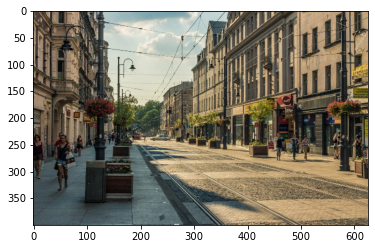

In [2]:
_imgpath = 'street.jpg'
img = cv.imread(_imgpath)
    
# размеры изображения
newH = 400  # высота
newW = int(img.shape[1]*newH/img.shape[0]) # ширина 
# сжатая картинка
img = cv.resize(img, (newW, newH)) 
# В RGB переводим
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Выводим 
plt.imshow(img)
plt.show()

In [3]:
#Настройка модели
cv.setUseOptimized(True) # режим оптимизации
cv.setNumThreads(12)  # количество потоков

In [4]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(img)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(13728, 4)


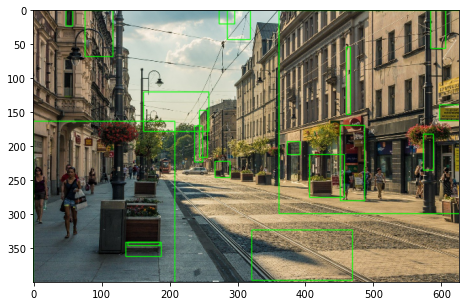

In [5]:
#Построим области

num_Rects = 20 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
_img = img.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
        x, y, w, h = rect
    # рисуем рамку      
        cv.rectangle(_img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
    else: 
        break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(_img) 
plt.show()

In [6]:
# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpeg")
    response = urlopen(url)
    image_data = response.read()
  #read image
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
        text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Возвращаем рамки для объектов

In [7]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    if len(image.shape)>3:
        image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
    I_shape=np.uint8(image).shape
  #print(I_shape)
    im_array=[]
    for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])


            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            #print(imf.shape,imf[0,0,:])

            im_array.append(imf.copy())  
    return im_array

In [8]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""

    image_pil = np.array(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)

    return imf

In [9]:
module_handle_ssd = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
ssd_mobilenet = hub.load(module_handle_ssd).signatures['default']

module_handle_inception = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
inception = hub.load(module_handle_inception).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Обработка изображения для передачи в детектор:

Формируем тензор

In [10]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

Выполняем детектор

In [11]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
  #print(result['detection_scores'])
    result = {key:value.numpy() for key,value in result.items()} 

    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)

    display_image(image_with_boxes)
    return result

Проверяем детектор

In [12]:
ssd_mobilenet_result = run_detector(ssd_mobilenet, 'street.jpg')
inception_result = run_detector(inception, 'street.jpg')

Font not found, using default font.
Font not found, using default font.


In [13]:
ssd_mobilenet_result

{'detection_class_labels': array([462, 462, 391,  69,  69, 391, 434, 391, 485, 485, 434, 391, 462,
        485, 485, 462, 485, 485, 462,  69, 485, 485, 485, 485, 485, 462,
        391, 391, 485, 485, 485, 485, 485, 485, 485, 485, 391, 485, 485,
        485, 485, 485, 391, 391, 462, 485, 485, 391, 485, 485, 485, 485,
        485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 434, 485, 485,
        485, 391, 485, 485, 485, 391, 462, 485, 462,  69, 462, 485, 485,
        485, 485, 485, 462, 485, 462, 485, 462, 485, 485, 462, 485, 485,
         69, 485, 485, 485, 485, 485, 485, 485,  69], dtype=int64),
 'detection_class_names': array([b'/m/0cgh4', b'/m/0cgh4', b'/m/07j7r', b'/m/01g317', b'/m/01g317',
        b'/m/07j7r', b'/m/09j5n', b'/m/07j7r', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/09j5n', b'/m/07j7r', b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0cgh4', b'/m/01g317',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
  

(100, 100)

In [15]:
inception_result

{'detection_scores': array([0.76372266, 0.7022559 , 0.62403405, 0.61786586, 0.5853883 ,
        0.4999898 , 0.4864224 , 0.47128865, 0.47097808, 0.43801478,
        0.42818737, 0.38715813, 0.32166404, 0.32126096, 0.28757977,
        0.2713026 , 0.2593941 , 0.25422513, 0.23991802, 0.22509915,
        0.21841006, 0.21804972, 0.21727636, 0.21112327, 0.20304157,
        0.19268036, 0.1923902 , 0.1528438 , 0.14037846, 0.12798415,
        0.12162183, 0.09325841, 0.08839351, 0.08793654, 0.0872566 ,
        0.08708743, 0.08532846, 0.07856417, 0.07791661, 0.0739755 ,
        0.07379151, 0.06564757, 0.06263694, 0.05945948, 0.05376757,
        0.05195348, 0.0507717 , 0.04621127, 0.04490442, 0.04443698,
        0.04308129, 0.04179223, 0.04141068, 0.04106062, 0.03949128,
        0.03834007, 0.03682086, 0.03568371, 0.03562485, 0.03216619,
        0.03171322, 0.03161817, 0.03122773, 0.03093076, 0.03035604,
        0.03027401, 0.02886885, 0.027796  , 0.02681364, 0.02647158,
        0.02542434, 0.025348

In [ ]:
# кол-во найденных объектов
len(ssd_mobilenet_result['detection_class_labels']), len(inception_result['detection_class_labels'])